<h1> DL ASSIGNMENT 1 </h1>

<br><br><br>
<h3>Q1) Dataset and Dataloader </h3>

In [1]:
# !git clone https://github.com/arjit-0602/MNIST-dataset.git
# !cp /content/MNIST-dataset/MNIST_DATASET.tar.xz /content
# !tar -xJf MNIST_DATASET.tar.xz
!pip install idx2numpy

  Preparing metadata (setup.py) ... done
  Created wheel for idx2numpy: filename=idx2numpy-1.2.3-py3-none-any.whl size=7905 sha256=54a4357846b877cfab81178e513382a8dba4f78b3a94d56b38ac4a87aab36b0d
  Stored in directory: /root/.cache/pip/wheels/e0/f4/e7/643fc5f932ec2ff92997f43f007660feb23f948aa8486f1107
Successfully built idx2numpy


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, transforms
from pandas.core.common import flatten
import time
import matplotlib.pyplot as plt
import gdown
import glob
import random
import cv2
import os
import idx2numpy
import numpy as np
from PIL import Image
import math
from sklearn.model_selection import train_test_split

In [3]:
def download_mnist_dataset():
    train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform) # -> 60k images (86% of the total)
    test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform) # -> 10k images (14% of the total)
    train_size = 50000 # 84% for training -> 50k images
    val_size = 10000 # 16% for validation -> 10k images ( so as to be same with testing )
    train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])
    return train_dataset,val_dataset,test_dataset

    # final splits -> (train, validation , test) -> (72% , 14% , 14%)


def convert_binary_to_images(images_filename,labels_filename):
    images_array = np.array(idx2numpy.convert_from_file(images_filename))
    labels_array = np.array(idx2numpy.convert_from_file(labels_filename))
    return images_array,labels_array


def train_validation_split(train_images,train_labels):
    train_size = 50000 # 84% for training -> 50k images
    val_size = 10000 # 16% for validation -> 10k images ( so as to be same with testing )
    train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels,train_size=train_size, test_size=val_size, random_state=42)
    return train_images,train_labels,val_images,val_labels


transform = transforms.Compose([transforms.ToTensor()]) #, transforms.Normalize((0,), (1,))])
train_images_path,train_labels_path="/content/data/MNIST/raw/train-images-idx3-ubyte","/content/data/MNIST/raw/train-labels-idx1-ubyte"
test_images_path,test_labels_path="/content/data/MNIST/raw/t10k-images-idx3-ubyte","/content/data/MNIST/raw/t10k-labels-idx1-ubyte"



inbuilt_train_dataset,inbuilt_val_dataset,inbuilt_test_dataset=download_mnist_dataset()

train_images,train_labels=convert_binary_to_images(train_images_path,train_labels_path)
test_images,test_labels=convert_binary_to_images(test_images_path,test_labels_path)
train_images,train_labels,val_images,val_labels=train_validation_split(train_images,train_labels)

100%|██████████| 9912422/9912422 [00:00<00:00, 93039055.02it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 73638719.65it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 30431090.70it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 5042490.41it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



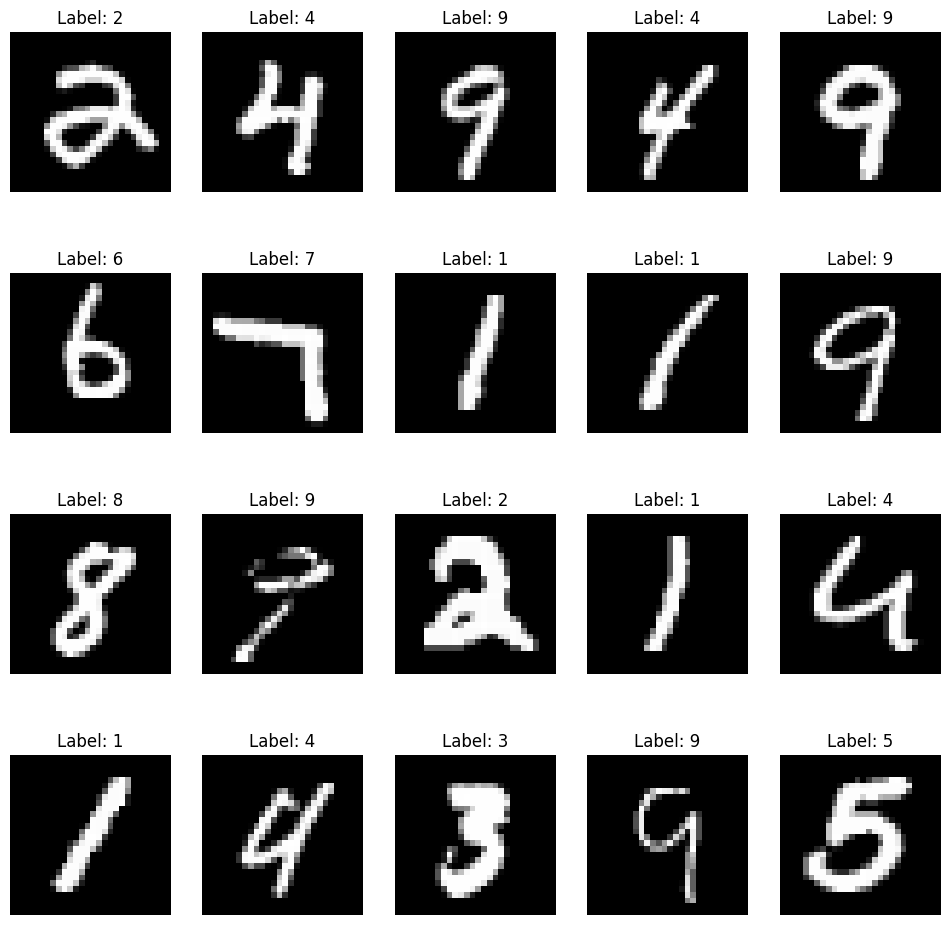

In [ ]:
def display_random_images():
    num_images_to_display = 20
    num_rows = 4
    num_cols = num_images_to_display // num_rows

    random_indices = torch.randperm(len(train_images_path))[:num_images_to_display]
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 12))

    for i in range(num_rows):
        for j in range(num_cols):
            index = random_indices[i * num_cols + j]
            image= train_images[index]
            label=train_labels[index]
            axes[i, j].imshow(image, cmap='gray')
            axes[i, j].set_title(f'Label: {label}')
            axes[i, j].axis('off')
    plt.show()




display_random_images()

<h3> Custom Implementation </h3>

In [4]:
class CustomDataset(Dataset):
      def __init__(self, images,labels,transform):
            self.images = images
            self.labels= labels
            self.transform = transform

      def __len__(self):
            return len(self.images)

      def __getitem__(self, idx):
            image=self.images[idx]
            if self.transform is not None:
                image = self.transform(image)
            label=self.labels[idx]
            return (image, label)


# # Custom DataLoader
def create_dataloader(dataset, batch_size):
    return DataLoader(dataset, batch_size=batch_size, shuffle=True,pin_memory=True,num_workers=4)


<h3> Implementation from Scratch </h3>

In [5]:
class ScratchDataset:
    def __init__(self, images,labels,transform):
        self.images = images
        self.labels= labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image=self.images[idx]
        if self.transform is not None:
            image = self.transform(image)
        label=self.labels[idx]
        return (image, label)



class ScratchDataLoader:
    def __init__(self, dataset, batch_size=1, shuffle=True):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indices = list(range(len(dataset)))
        self.index = 0

        if self.shuffle:
            self.shuffle_data()

    def shuffle_data(self):
        random.shuffle(self.indices)

    def __iter__(self):
        self.index = 0
        return self

    def __next__(self):
        if self.index >= len(self.dataset):
            self.index = 0
            raise StopIteration

        batch_indices = self.indices[self.index:self.index + self.batch_size]
        batch_images = [self.dataset[i][0] for i in batch_indices]
        batch_labels = [self.dataset[i][1] for i in batch_indices]
        self.index += self.batch_size

        return torch.stack(batch_images), torch.tensor(batch_labels)

    def __len__(self):
        return math.ceil(len(self.dataset) / self.batch_size)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


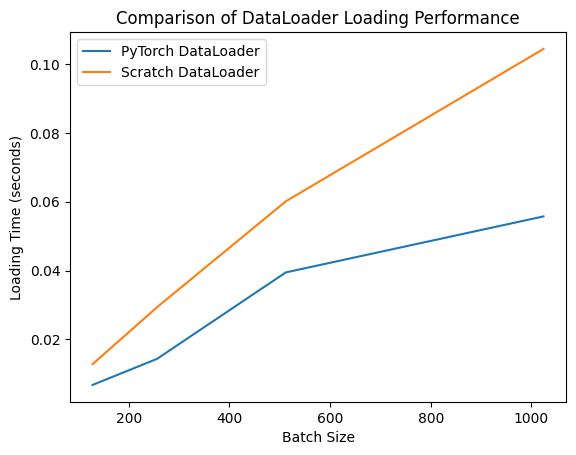

In [6]:
def measure_loading_time(dataloader):
    start_time = time.time()
    for _ in dataloader:
            pass
    end_time = time.time()
    return (end_time - start_time)/len(dataloader)


transform = transforms.Compose([transforms.ToTensor()]) #, transforms.Normalize((0,), (1,))])



# Example usage with GPU (if available)
batch_sizes = [128, 256, 512, 1024]
loading_times_pytorch = []
loading_times_scratch = []



# Move dataset to GPU if available
device = torch.device('cuda') # if torch.cuda.is_available() else 'cpu')


# train_dataset = CustomDataset(train_images,train_labels,transform)
# pytorch_train_dataset=train_images
pytorch_train_dataset=CustomDataset(train_images,train_labels,transform)
scratch_train_dataset=ScratchDataset(train_images,train_labels,transform)

for batch_size in batch_sizes:
    # PyTorch DataLoader
    pytorch_train_dataloader = create_dataloader(pytorch_train_dataset, batch_size)
    loading_time_pytorch = measure_loading_time(pytorch_train_dataloader)
    loading_times_pytorch.append(loading_time_pytorch)

    # Scratch DataLoader
    scratch_train_dataloader = ScratchDataLoader(scratch_train_dataset, batch_size)
    loading_time_scratch = measure_loading_time(scratch_train_dataloader)
    loading_times_scratch.append(loading_time_scratch)



# Plotting the results
plt.plot(batch_sizes, loading_times_pytorch, label='PyTorch DataLoader')
plt.plot(batch_sizes, loading_times_scratch, label='Scratch DataLoader')
plt.xlabel('Batch Size')
plt.ylabel('Loading Time (seconds)')
plt.legend()
plt.title('Comparison of DataLoader Loading Performance')
plt.show()

Pytorch implemented Dataloader is better. Also loading time is increasing with batch size as expected . This is because (load time= time for loading entire dataset/ no. of batches) and (no. of batches = size of dataset/ batch size). So basically load time is directly prop to batch size. Hence time inc with size.

<br><br><br>
<h3>Q2) Feedforward Neural Net using inbuilt Pytorch functionality </h3>


In [ ]:
# Define the neural network architecture
class FeedForwardNN(nn.Module):
    def __init__(self,activation_function):
        super(FeedForwardNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 512) #input layer
        self.bn1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 256) #hidden layer 1
        self.bn2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, 128) #hidden layer 2
        self.bn3 = nn.BatchNorm1d(128)
        self.fc4 = nn.Linear(128, 64)   #hidden layer 3
        self.bn4 = nn.BatchNorm1d(64)
        self.fc5 = nn.Linear(64, 32)   #hidden layer 4
        self.bn5 = nn.BatchNorm1d(32)
        self.fc6 = nn.Linear(32, 10)   #output layer
        self.activation_function = activation_function


    def forward(self, x):
        x= x.view(-1,28*28)
        x= self.fc1(x)
        x= self.bn1(x)
        x= self.activation_function(x)
        x= self.fc2(x)
        x= self.bn2(x)
        x= self.activation_function(x)
        x= self.fc3(x)
        x= self.bn3(x)
        x= self.activation_function(x)
        x= self.fc4(x)
        x= self.bn4(x)
        x= self.activation_function(x)
        x= self.fc5(x)
        x= self.bn5(x)
        x= self.activation_function(x)
        x= self.fc6(x)
        return x



# Function to train the model
def inbuilt_train_and_test_model(model, train_loader, val_loader, test_loader, criterion, optimizer, num_epochs=60,clip_value=None):
    train_losses, val_losses, test_losses, train_accuracies, val_accuracies, test_accuracies = [], [], [], [], [], []

    for epoch in range(num_epochs):

        # training mode of model
        model.train()
        total_loss, correct, total = 0, 0, 0

        for inputs, labels in train_loader:
            optimizer.zero_grad()  # clear the previous grads because the new ones shouldn't be dependent on them (pytorch inherently stores them)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()  # backpropagates the losses

            # torch.nn.utils.clip_grad_norm_(model_sigmoid.parameters(), clip_value) #only for sigmoid

            optimizer.step() # updates all the gradients of previous layers
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1) # softmax probs to highest prob class
            total += labels.size(0) # get the no. of samples in a batch
            correct += (predicted == labels).sum().item() # no. of correct

        train_loss = total_loss/len(train_loader)
        train_accuracy = correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)




        # Validation
        model.eval()   #evaluation mode of model
        val_loss, val_correct, val_total = 0, 0, 0

        with torch.no_grad(): # autograd stops gradient computation to yield faster results
            for val_inputs, val_labels in val_loader:
                val_outputs = model(val_inputs)
                val_loss += criterion(val_outputs, val_labels).item()
                _, val_predicted = torch.max(val_outputs.data, 1)
                val_total += val_labels.size(0)
                val_correct += (val_predicted == val_labels).sum().item()

        val_loss/=len(val_loader)
        val_accuracy = val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)




        #test
        test_loss,test_correct,test_total=0,0,0

        with torch.no_grad():
            for test_inputs, test_labels in test_loader:
                test_outputs = model(test_inputs)
                test_loss += criterion(test_outputs, test_labels).item()
                _, test_predicted = torch.max(test_outputs.data, 1)
                test_total += test_labels.size(0)
                test_correct += (test_predicted == test_labels).sum().item()

        test_loss/=len(test_loader)
        test_accuracy = test_correct / test_total
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)



        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}, '
              f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f} ',
              f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')


    return train_losses, val_losses, test_losses, train_accuracies, val_accuracies, test_accuracies

Epoch 1/60, Train Loss: 2.0479, Accuracy: 0.2979, Val Loss: 1.8022, Val Accuracy: 0.5464  Test Loss: 1.7888, Test Accuracy: 0.5529
Epoch 2/60, Train Loss: 1.6900, Accuracy: 0.6387, Val Loss: 1.5569, Val Accuracy: 0.7385  Test Loss: 1.5414, Test Accuracy: 0.7436
Epoch 3/60, Train Loss: 1.4828, Accuracy: 0.7628, Val Loss: 1.3721, Val Accuracy: 0.8057  Test Loss: 1.3543, Test Accuracy: 0.8149
Epoch 4/60, Train Loss: 1.3230, Accuracy: 0.8120, Val Loss: 1.2345, Val Accuracy: 0.8395  Test Loss: 1.2136, Test Accuracy: 0.8486
Epoch 5/60, Train Loss: 1.1873, Accuracy: 0.8403, Val Loss: 1.1099, Val Accuracy: 0.8620  Test Loss: 1.0917, Test Accuracy: 0.8742
Epoch 6/60, Train Loss: 1.0672, Accuracy: 0.8590, Val Loss: 0.9871, Val Accuracy: 0.8780  Test Loss: 0.9676, Test Accuracy: 0.8904
Epoch 7/60, Train Loss: 0.9637, Accuracy: 0.8733, Val Loss: 0.8962, Val Accuracy: 0.8878  Test Loss: 0.8747, Test Accuracy: 0.8999
Epoch 8/60, Train Loss: 0.8766, Accuracy: 0.8818, Val Loss: 0.8097, Val Accuracy: 0

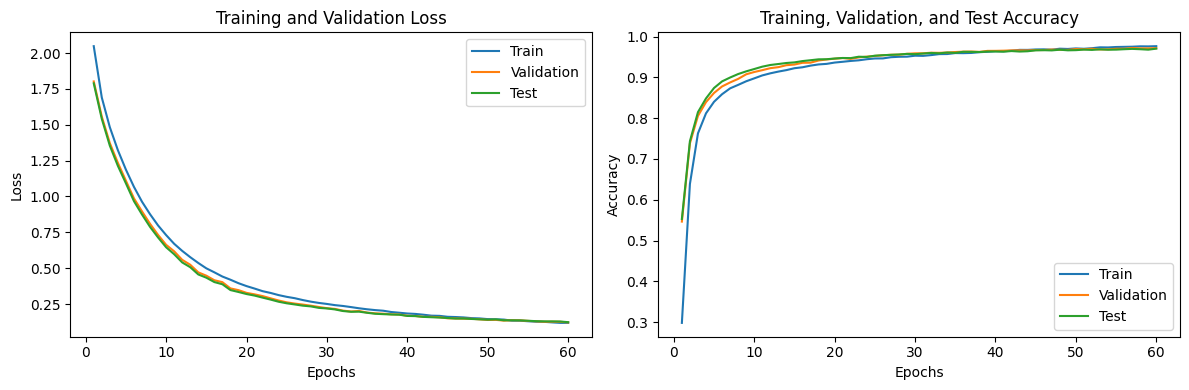

In [ ]:
# Set random seed for reproducibility
seed = 5
torch.manual_seed(seed)



# Train the model
# Create the model, loss function, and optimizer
activation_function_relu = nn.ReLU()
model_relu = FeedForwardNN(activation_function_relu)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_relu.parameters(), lr=0.0003)
batch_size = 64


train_dataset = CustomDataset(train_images,train_labels,transform)
val_dataset = CustomDataset(val_images,val_labels,transform)
test_dataset = CustomDataset(test_images,test_labels,transform)
train_dataloader = create_dataloader(train_dataset, batch_size)
val_dataloader = create_dataloader(val_dataset, batch_size)
test_dataloader = create_dataloader(test_dataset, batch_size)

train_losses, val_losses, test_losses, train_accuracies, val_accuracies, test_accuracies = inbuilt_train_and_test_model(model_relu, train_dataloader, val_dataloader, test_dataloader , criterion, optimizer, num_epochs=60)

# final_test_loss = test_losses[-1]
# final_test_accuracy = test_accuracies[-1]

# Plotting loss and accuracy graphs
epochs_range=range(1, 61)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Train')
plt.plot(epochs_range, val_losses, label='Validation')
plt.plot(epochs_range, test_losses, label='Test')
# plt.axhline(y=final_test_loss, color='r', linestyle='--', label='Test')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Train')
plt.plot(epochs_range, val_accuracies, label='Validation')
plt.plot(epochs_range, test_accuracies, label='Test')
# plt.axhline(y=final_test_accuracy, color='r', linestyle='--', label='Test')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training, Validation, and Test Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

<b>85% without batch norm(batch_size=32) and 50%(batch_size=64)<br>
97% with Batch Norm</b><br><br>

Decreasing the batch size increased the accuracy because a smaller batch size allows the model to learn from each individual example but takes longer to train. Especially since SGD uses a random example to update the weight parameters , if we use a smaller batch then the randomization is limited to only a small no. of examples instead of a large no.  <br><br>

Batch Normalization (BatchNorm) is a technique used in neural networks during training to normalize the input of each layer. It involves adjusting and scaling the activations so that they have a mean close to zero and a standard deviation close to one. This normalization helps in stabilizing and speeding up the training of deep neural networks. It involves two main steps: normalizing the inputs based on the mean and standard deviation of the current mini-batch, and then scaling and shifting the normalized values using learnable parameters. Batch Normalization contributes to faster convergence, reduced sensitivity to weight initialization, slight regularization, and improved generalization in deep learning models.

<br><br><br>
<h3> Q3) Feedforward Neural Net from Scratch </h3>

In [7]:
class Relu:
      def __init__(self):
          pass

      def forward(self,x,fc):
          post_activation= torch.max(torch.tensor(0, dtype=x.dtype), x)
          fc.a=post_activation  # store post activation in respective layer
          return post_activation

      def derivative(self,x):
           zero_tensor = torch.tensor(0, dtype=x.dtype)
           return torch.where(x < 0, zero_tensor, torch.tensor(1, dtype=x.dtype))



class Sigmoid:
      def __init__(self):
          pass

      def compute(self,x):
         return 1/ (1+ torch.exp(-1*x))

      def derivative(self,x):
          return self.compute(x) * (1 - self.compute(x))

      def forward(self,x,fc):
          post_activation= 1/ (1+ torch.exp(-1*x))
          fc.a=post_activation  # store post activation in respective layer
          return post_activation




class Softmax:
      def __init__(self):
         pass

      def forward(self,x):
          exp_x = torch.exp(x - torch.max(x, dim=-1, keepdim=True).values)  # Subtract max for numerical stability
          softmax_x = exp_x / torch.sum(exp_x, dim=-1, keepdim=True)
          return softmax_x



class CrossEntropyLossScratch:
      def __init__(self):
          self.softmax=Softmax()


      def forward(self,logits,targets):
          targets = targets.long()
          targets = F.one_hot(targets, num_classes=logits.size(1)).float()
          epsilon = 1e-12
          probs= self.softmax.forward(logits)
          probs = torch.clamp(probs, epsilon, 1 - epsilon) # clamp the prob so that log 0 doesnt give error
          loss = -torch.sum(targets * torch.log(probs)) / probs.size(0)

          self.delta=probs-targets # error differnce in last layer
          return loss


      def backward(self,model): #compute grads of all layers (backpropagate the grads) - backpropagation
          fc1=model.fc1
          fc2=model.fc2
          fc3=model.fc3
          fc4=model.fc4
          fc5=model.fc5
          fc6=model.fc6

          # error difference in all hidden layers
          self.delta5=torch.matmul(self.delta, fc6.weights.t()) * model.activation_func.derivative(fc5.a)
          self.delta4=torch.matmul(self.delta5, fc5.weights.t()) * model.activation_func.derivative(fc4.a)
          self.delta3=torch.matmul(self.delta4, fc4.weights.t()) * model.activation_func.derivative(fc3.a)
          self.delta2=torch.matmul(self.delta3, fc3.weights.t()) * model.activation_func.derivative(fc2.a)
          self.delta1=torch.matmul(self.delta2, fc2.weights.t()) * model.activation_func.derivative(fc1.a)


         # grads of all layers - erros after curr layer (a function of final probs and target error and activation funcs) * post activations from prev layer
          model.fc6.weight_grads=torch.matmul(fc5.a.t(),self.delta)
          model.fc6.bias_grads=torch.sum(self.delta, axis=0, keepdims=True)

          model.fc5.weight_grads=torch.matmul(fc4.a.t(),self.delta5)
          model.fc5.bias_grads=torch.sum(self.delta5, axis=0, keepdims=True)

          model.fc4.weight_grads=torch.matmul(fc3.a.t(),self.delta4)
          model.fc4.bias_grads=torch.sum(self.delta4, axis=0, keepdims=True)

          model.fc3.weight_grads=torch.matmul(fc2.a.t(),self.delta3)
          model.fc3.bias_grads=torch.sum(self.delta3, axis=0, keepdims=True)

          model.fc2.weight_grads=torch.matmul(fc1.a.t(),self.delta2)
          model.fc2.bias_grads=torch.sum(self.delta2, axis=0, keepdims=True)

          model.fc1.weight_grads=torch.matmul(model.x.t(),self.delta1)
          model.fc1.bias_grads=torch.sum(self.delta1, axis=0, keepdims=True)





class StochasticGD:
      def __init__(self,learning_rate,clip_value=None):
          self.learning_rate=learning_rate
          self.clip_value =clip_value

      def weight_update(self,fc):
          params=fc.weights
          bias=fc.bias
          weight_grads=fc.weight_grads
          bias_grads=fc.bias_grads

          if self.clip_value is not None:  #gradient clipping to solve exploding grads problem
            weight_grads = torch.clamp(weight_grads, -self.clip_value, self.clip_value)
            bias_grads = torch.clamp(bias_grads, -self.clip_value, self.clip_value)


          fc.weights=fc.weights - self.learning_rate*weight_grads
          fc.bias=fc.bias - self.learning_rate*bias_grads


      def step(self,model): #update weights of layers in dec order
          self.weight_update(model.fc6)
          self.weight_update(model.fc5)
          self.weight_update(model.fc4)
          self.weight_update(model.fc3)
          self.weight_update(model.fc2)
          self.weight_update(model.fc1)



In [8]:
class Linear:
      def __init__(self,input_size,output_size):
          self.input_size=input_size
          self.output_size=output_size
          self.weights = torch.randn(input_size, output_size)
          self.bias = torch.zeros(output_size)
          self.weight_grads=0
          self.bias_grads=0
          self.a=0  # a is post activation (will be updated after applying relu)

      def forward(self,x):
          self.z=torch.mm(x,self.weights) + self.bias # z is preactivation
          return self.z


class FeedForwardNet:
    def __init__(self, input_size, hidden_size, num_classes,activation_function=Relu()):
        self.fc1=Linear(input_size,hidden_size)
        self.fc2=Linear(hidden_size,hidden_size)
        self.fc3=Linear(hidden_size,hidden_size)
        self.fc4=Linear(hidden_size,hidden_size)
        self.fc5=Linear(hidden_size,hidden_size)
        self.fc6=Linear(hidden_size,num_classes)

        self.activation_func=activation_function

    def forward(self, x):  #forward propagation
        x = x.view(-1,28*28)

        self.x=x
        x = self.activation_func.forward(self.fc1.forward(x),self.fc1)
        x = self.activation_func.forward(self.fc2.forward(x),self.fc2)
        x = self.activation_func.forward(self.fc3.forward(x),self.fc3)
        x = self.activation_func.forward(self.fc4.forward(x),self.fc4)
        x = self.activation_func.forward(self.fc5.forward(x),self.fc5)
        x = self.fc6.forward(x)
        return x



# Function to train the model
def scratch_train_and_test_model(model, train_loader, val_loader, test_loader, criterion, optimizer, num_epochs=60):
    train_losses, val_losses, test_losses, train_accuracies, val_accuracies, test_accuracies = [], [], [], [], [], []

    for epoch in range(num_epochs):

        # training mode of model
        total_loss, correct, total = 0, 0, 0

        for inputs, labels in train_loader:
            # optimizer.zero_grad()  # clear the previous grads because the new ones shouldn't be dependent on them (pytorch inherently stores them)
            outputs = model.forward(inputs)
            loss = criterion.forward(outputs, labels)
            criterion.backward(model)  # backpropagates the losses --------
            optimizer.step(model) # updates all the gradients of previous layers

            total_loss += loss
            _, predicted = torch.max(outputs.data, 1) # softmax probs to highest prob class
            total += labels.size(0) # get the no. of samples in a batch
            correct += (predicted == labels).sum().item() # no. of correct

        train_loss = total_loss / len(train_loader)
        train_accuracy = correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)



        # Validation
        val_loss, val_correct, val_total = 0, 0, 0
        for val_inputs, val_labels in val_loader:
            val_outputs = model.forward(val_inputs)
            val_loss += criterion.forward(val_outputs, val_labels)
            _, val_predicted = torch.max(val_outputs.data, 1)
            val_total += val_labels.size(0)
            val_correct += (val_predicted == val_labels).sum().item()

        val_loss/=len(val_loader)
        val_accuracy = val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)




        # #test
        test_loss,test_correct,test_total=0,0,0
        for test_inputs, test_labels in test_loader:
            test_outputs = model.forward(test_inputs)
            test_loss += criterion.forward(test_outputs, test_labels)
            _, test_predicted = torch.max(test_outputs.data, 1)
            test_total += test_labels.size(0)
            test_correct += (test_predicted == test_labels).sum().item()

        test_loss/=len(test_loader)
        test_accuracy = test_correct / test_total
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)



        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}, ',
              f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f} ',
              f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')


    return train_losses, val_losses, test_losses, train_accuracies, val_accuracies, test_accuracies

Epoch 1/60, Train Loss: 9.8487, Accuracy: 0.6434,  Val Loss: 5.7445, Val Accuracy: 0.7926  Test Loss: 5.6510, Test Accuracy: 0.7960
Epoch 2/60, Train Loss: 4.9616, Accuracy: 0.8205,  Val Loss: 4.4383, Val Accuracy: 0.8395  Test Loss: 4.3641, Test Accuracy: 0.8428
Epoch 3/60, Train Loss: 4.0794, Accuracy: 0.8524,  Val Loss: 3.8994, Val Accuracy: 0.8594  Test Loss: 3.7756, Test Accuracy: 0.8633
Epoch 4/60, Train Loss: 3.6245, Accuracy: 0.8689,  Val Loss: 3.6931, Val Accuracy: 0.8666  Test Loss: 3.4291, Test Accuracy: 0.8756
Epoch 5/60, Train Loss: 3.3142, Accuracy: 0.8801,  Val Loss: 3.5886, Val Accuracy: 0.8698  Test Loss: 3.3714, Test Accuracy: 0.8780
Epoch 6/60, Train Loss: 3.1304, Accuracy: 0.8867,  Val Loss: 3.3807, Val Accuracy: 0.8773  Test Loss: 3.1156, Test Accuracy: 0.8876
Epoch 7/60, Train Loss: 2.9564, Accuracy: 0.8932,  Val Loss: 3.1046, Val Accuracy: 0.8874  Test Loss: 3.0276, Test Accuracy: 0.8902
Epoch 8/60, Train Loss: 2.8300, Accuracy: 0.8977,  Val Loss: 3.0029, Val Acc

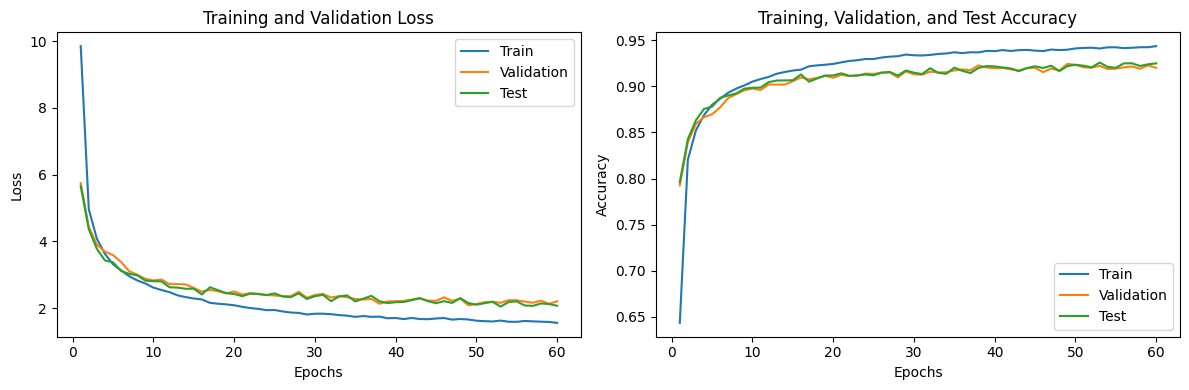

In [ ]:
# Set random seed for reproducibility
seed = 5
torch.manual_seed(seed)



# Train the model
# Create the model, loss function, and optimizer
activation_function_relu = Relu()
model_relu = FeedForwardNet(28*28,512,10,activation_function_relu)
criterion = CrossEntropyLossScratch()
optimizer = StochasticGD(0.0003,1.0)
batch_size = 64


train_dataset = CustomDataset(train_images,train_labels,transform)
val_dataset = CustomDataset(val_images,val_labels,transform)
test_dataset = CustomDataset(test_images,test_labels,transform)
train_dataloader = create_dataloader(train_dataset, batch_size)
val_dataloader = create_dataloader(val_dataset, batch_size)
test_dataloader = create_dataloader(test_dataset, batch_size)

train_losses, val_losses, test_losses, train_accuracies, val_accuracies, test_accuracies = scratch_train_and_test_model(model_relu, train_dataloader, val_dataloader, test_dataloader , criterion, optimizer, num_epochs=60)

# final_test_loss = test_losses[-1]
# final_test_accuracy = test_accuracies[-1]

# Plotting loss and accuracy graphs
epochs_range=range(1, 61)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Train')
plt.plot(epochs_range, val_losses, label='Validation')
plt.plot(epochs_range, test_losses, label='Test')
# plt.axhline(y=final_test_loss, color='r', linestyle='--', label='Test')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Train')
plt.plot(epochs_range, val_accuracies, label='Validation')
plt.plot(epochs_range, test_accuracies, label='Test')
# plt.axhline(y=final_test_accuracy, color='r', linestyle='--', label='Test')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training, Validation, and Test Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

<b>Scratch Implementation Accuracy- 92% (With Gradient clipping)<br><br></b>

<b>Pytorch Inbuilt - 85%(Without BatchNorm)  &  97%(With batch Norm) <br><br></b>

Initially the Scratch implementation was facing from the exploding gradient problem. The gradients were getting very high and overflowing . So the accuracy stopped inc after 9%. To solve this Gradient clipping technique was used. Gradient was clipped between -1 to 1 (gradient normalization c.||g|| / max(c,||g||)  with c=1 ).
This prevented it from exploding and increased the accuracy. <br><br>

For Pytorch inbuilt version Batch Norm is also solving this problem.  Batch normalization, by normalizing the inputs to each layer, can stabilize the training process and reduce the likelihood of exploding gradients. Normalizing inputs to have a mean around zero helps activations stay in the non-saturating region of the activation function, preserving the gradients and facilitating learning.

<br><br><br>
<h3> Q4) Implement the neural Net using sigmoid function (Scratch and inbuilt) </h3>

<h3> Inbuilt </h3>

Epoch 1/60, Train Loss: 2.2560, Accuracy: 0.1652, Val Loss: 2.1611, Val Accuracy: 0.2033  Test Loss: 2.1584, Test Accuracy: 0.2090
Epoch 2/60, Train Loss: 2.1128, Accuracy: 0.2682, Val Loss: 2.0689, Val Accuracy: 0.3438  Test Loss: 2.0647, Test Accuracy: 0.3539
Epoch 3/60, Train Loss: 2.0385, Accuracy: 0.4023, Val Loss: 2.0113, Val Accuracy: 0.4665  Test Loss: 2.0060, Test Accuracy: 0.4729
Epoch 4/60, Train Loss: 1.9871, Accuracy: 0.5308, Val Loss: 1.9693, Val Accuracy: 0.5872  Test Loss: 1.9634, Test Accuracy: 0.5946
Epoch 5/60, Train Loss: 1.9471, Accuracy: 0.6344, Val Loss: 1.9308, Val Accuracy: 0.6702  Test Loss: 1.9248, Test Accuracy: 0.6836
Epoch 6/60, Train Loss: 1.9130, Accuracy: 0.6970, Val Loss: 1.9010, Val Accuracy: 0.7256  Test Loss: 1.8946, Test Accuracy: 0.7339
Epoch 7/60, Train Loss: 1.8838, Accuracy: 0.7344, Val Loss: 1.8744, Val Accuracy: 0.7509  Test Loss: 1.8674, Test Accuracy: 0.7574
Epoch 8/60, Train Loss: 1.8581, Accuracy: 0.7593, Val Loss: 1.8515, Val Accuracy: 0

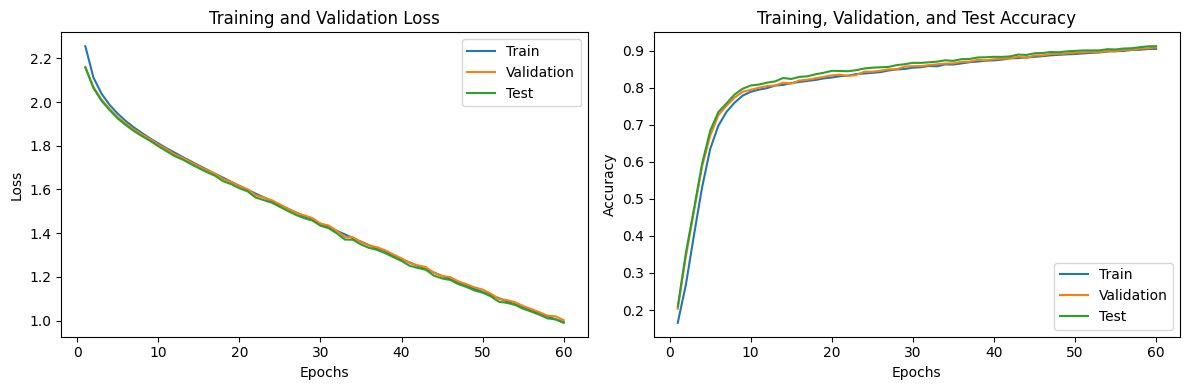

In [ ]:
# Set random seed for reproducibility
seed = 5
torch.manual_seed(seed)



# Train the model
# Create the model, loss function, and optimizer
activation_function_sigmoid = nn.Sigmoid()
model_sigmoid = FeedForwardNN(activation_function_sigmoid)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_sigmoid.parameters(), lr=0.0003)
batch_size = 64


train_dataset = CustomDataset(train_images,train_labels,transform)
val_dataset = CustomDataset(val_images,val_labels,transform)
test_dataset = CustomDataset(test_images,test_labels,transform)
train_dataloader = create_dataloader(train_dataset, batch_size)
val_dataloader = create_dataloader(val_dataset, batch_size)
test_dataloader = create_dataloader(test_dataset, batch_size)

train_losses, val_losses, test_losses, train_accuracies, val_accuracies, test_accuracies = inbuilt_train_and_test_model(model_sigmoid, train_dataloader, val_dataloader, test_dataloader , criterion, optimizer,60)

# final_test_loss = test_losses[-1]
# final_test_accuracy = test_accuracies[-1]

# Plotting loss and accuracy graphs
epochs_range=range(1, 61)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Train')
plt.plot(epochs_range, val_losses, label='Validation')
plt.plot(epochs_range, test_losses, label='Test')
# plt.axhline(y=final_test_loss, color='r', linestyle='--', label='Test')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Train')
plt.plot(epochs_range, val_accuracies, label='Validation')
plt.plot(epochs_range, test_accuracies, label='Test')
# plt.axhline(y=final_test_accuracy, color='r', linestyle='--', label='Test')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training, Validation, and Test Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


Just simply running the model with sigmoid was giving a vanishing gradient problem. After 3-4 iterations the accuracy <b>(11.35%)</b> and loss stopped changing. This meant that weight update was not happening. <br><br>

The issue arises because sigmoid(and tanh) function saturate for extreme input values, causing their derivatives to approach zero. When backpropagating through many layers, the gradients can multiply together, leading to an overall gradient that is close to zero. As a result, the weights of the early layers receive very small updates during optimization, and these layers effectively stop learning. <br><br>

After doing Batch Normalization the accuracy increased to <b>91%</b>.
BatchNorm has a beneficial side effect of reducing the vanishing gradient problem. By normalizing the inputs, it prevents extreme values that lead to saturation of activation functions. Normalizing inputs to have a mean around zero helps activations stay in the non-saturating region of the activation function, preserving the gradients and facilitating learning. <br><br>


<h3> Scratch </h3>

Epoch 1/60, Train Loss: 4.0769, Accuracy: 0.4636,  Val Loss: 2.1813, Val Accuracy: 0.6618  Test Loss: 2.1558, Test Accuracy: 0.6610
Epoch 2/60, Train Loss: 1.7812, Accuracy: 0.7259,  Val Loss: 1.5804, Val Accuracy: 0.7579  Test Loss: 1.5054, Test Accuracy: 0.7717
Epoch 3/60, Train Loss: 1.3913, Accuracy: 0.7907,  Val Loss: 1.2709, Val Accuracy: 0.8046  Test Loss: 1.2312, Test Accuracy: 0.8120
Epoch 4/60, Train Loss: 1.2094, Accuracy: 0.8180,  Val Loss: 1.1128, Val Accuracy: 0.8280  Test Loss: 1.1262, Test Accuracy: 0.8289
Epoch 5/60, Train Loss: 1.0905, Accuracy: 0.8343,  Val Loss: 1.0134, Val Accuracy: 0.8437  Test Loss: 1.0158, Test Accuracy: 0.8424
Epoch 6/60, Train Loss: 1.0037, Accuracy: 0.8454,  Val Loss: 0.9950, Val Accuracy: 0.8456  Test Loss: 0.9548, Test Accuracy: 0.8510
Epoch 7/60, Train Loss: 0.9301, Accuracy: 0.8565,  Val Loss: 0.8991, Val Accuracy: 0.8614  Test Loss: 0.8832, Test Accuracy: 0.8617
Epoch 8/60, Train Loss: 0.8694, Accuracy: 0.8639,  Val Loss: 0.8786, Val Acc

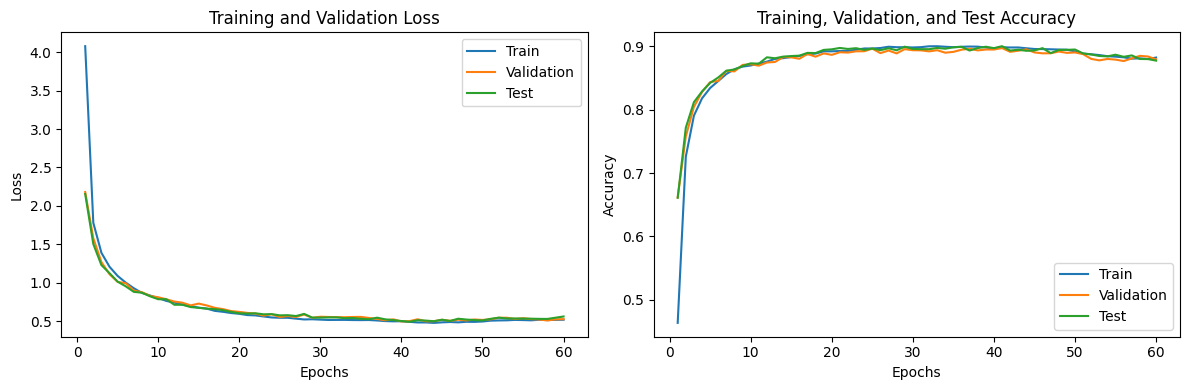

In [ ]:
# Set random seed for reproducibility
seed = 5
torch.manual_seed(seed)



# Train the model
# Create the model, loss function, and optimizer
activation_function_sigmoid = Sigmoid()
model_sigmoid = FeedForwardNet(28*28,512,10,activation_function_sigmoid)
criterion = CrossEntropyLossScratch()
optimizer = StochasticGD(0.0003,1.0)
batch_size = 64


train_dataset = CustomDataset(train_images,train_labels,transform)
val_dataset = CustomDataset(val_images,val_labels,transform)
test_dataset = CustomDataset(test_images,test_labels,transform)
train_dataloader = create_dataloader(train_dataset, batch_size)
val_dataloader = create_dataloader(val_dataset, batch_size)
test_dataloader = create_dataloader(test_dataset, batch_size)

train_losses, val_losses, test_losses, train_accuracies, val_accuracies, test_accuracies = scratch_train_and_test_model(model_sigmoid, train_dataloader, val_dataloader, test_dataloader , criterion, optimizer, num_epochs=60)

# final_test_loss = test_losses[-1]
# final_test_accuracy = test_accuracies[-1]

# Plotting loss and accuracy graphs
epochs_range=range(1, 61)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Train')
plt.plot(epochs_range, val_losses, label='Validation')
plt.plot(epochs_range, test_losses, label='Test')
# plt.axhline(y=final_test_loss, color='r', linestyle='--', label='Test')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Train')
plt.plot(epochs_range, val_accuracies, label='Validation')
plt.plot(epochs_range, test_accuracies, label='Test')
# plt.axhline(y=final_test_accuracy, color='r', linestyle='--', label='Test')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training, Validation, and Test Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


Accuracy of Scratch implementation for Sigmoid- 90%

<br><br><br>
<h3> BONUS Q1) Varying hidden layers </h3>

In [ ]:
# Define the neural network architecture
class FeedForwardNN(nn.Module):
    def __init__(self, input_size=28*28, hidden_size=512, num_hidden_layers=5, output_size=10, activation_function=nn.ReLU()):
        super(FeedForwardNN, self).__init__()

        layers = [nn.Linear(input_size, hidden_size), nn.BatchNorm1d(hidden_size), activation_function]

        for _ in range(num_hidden_layers - 1):
            layers.extend([nn.Linear(hidden_size, hidden_size), nn.BatchNorm1d(hidden_size), activation_function])

        layers.append(nn.Linear(hidden_size, output_size))

        self.layers = nn.ModuleList(layers)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        for layer in self.layers:
            x = layer(x)
        return x



# Function to train the model
def inbuilt_train_and_test_model(model, train_loader, val_loader, test_loader, criterion, optimizer, num_epochs=60,clip_value=None):
    train_losses, val_losses, test_losses, train_accuracies, val_accuracies, test_accuracies = [], [], [], [], [], []

    for epoch in range(num_epochs):

        # training mode of model
        model.train()
        total_loss, correct, total = 0, 0, 0

        for inputs, labels in train_loader:
            optimizer.zero_grad()  # clear the previous grads because the new ones shouldn't be dependent on them (pytorch inherently stores them)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()  # backpropagates the losses

            # torch.nn.utils.clip_grad_norm_(model_sigmoid.parameters(), clip_value) #only for sigmoid

            optimizer.step() # updates all the gradients of previous layers
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1) # softmax probs to highest prob class
            total += labels.size(0) # get the no. of samples in a batch
            correct += (predicted == labels).sum().item() # no. of correct

        train_loss = total_loss/len(train_loader)
        train_accuracy = correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)




        # Validation
        model.eval()   #evaluation mode of model
        val_loss, val_correct, val_total = 0, 0, 0

        with torch.no_grad(): # autograd stops gradient computation to yield faster results
            for val_inputs, val_labels in val_loader:
                val_outputs = model(val_inputs)
                val_loss += criterion(val_outputs, val_labels).item()
                _, val_predicted = torch.max(val_outputs.data, 1)
                val_total += val_labels.size(0)
                val_correct += (val_predicted == val_labels).sum().item()

        val_loss/=len(val_loader)
        val_accuracy = val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)




        #test
        test_loss,test_correct,test_total=0,0,0

        with torch.no_grad():
            for test_inputs, test_labels in test_loader:
                test_outputs = model(test_inputs)
                test_loss += criterion(test_outputs, test_labels).item()
                _, test_predicted = torch.max(test_outputs.data, 1)
                test_total += test_labels.size(0)
                test_correct += (test_predicted == test_labels).sum().item()

        test_loss/=len(test_loader)
        test_accuracy = test_correct / test_total
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)



        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}, '
              f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f} ',
              f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')


    return train_losses, val_losses, test_losses, train_accuracies, val_accuracies, test_accuracies

Epoch 1/60, Train Loss: 2.3249, Accuracy: 0.1168, Val Loss: 2.5813, Val Accuracy: 0.1421  Test Loss: 2.6912, Test Accuracy: 0.1451
Epoch 2/60, Train Loss: 2.2106, Accuracy: 0.1689, Val Loss: 2.3867, Val Accuracy: 0.1666  Test Loss: 2.4135, Test Accuracy: 0.1779
Epoch 3/60, Train Loss: 2.1471, Accuracy: 0.1985, Val Loss: 2.1620, Val Accuracy: 0.1998  Test Loss: 2.1588, Test Accuracy: 0.2159
Epoch 4/60, Train Loss: 2.0113, Accuracy: 0.2704, Val Loss: 2.0196, Val Accuracy: 0.3163  Test Loss: 2.0460, Test Accuracy: 0.3158
Epoch 5/60, Train Loss: 1.7739, Accuracy: 0.3838, Val Loss: 1.8558, Val Accuracy: 0.3644  Test Loss: 1.8856, Test Accuracy: 0.3686
Epoch 6/60, Train Loss: 1.5604, Accuracy: 0.4639, Val Loss: 1.6247, Val Accuracy: 0.3884  Test Loss: 1.6527, Test Accuracy: 0.3894
Epoch 7/60, Train Loss: 1.3953, Accuracy: 0.5173, Val Loss: 1.5579, Val Accuracy: 0.3979  Test Loss: 1.5604, Test Accuracy: 0.3972
Epoch 8/60, Train Loss: 1.2869, Accuracy: 0.5517, Val Loss: 1.3705, Val Accuracy: 0

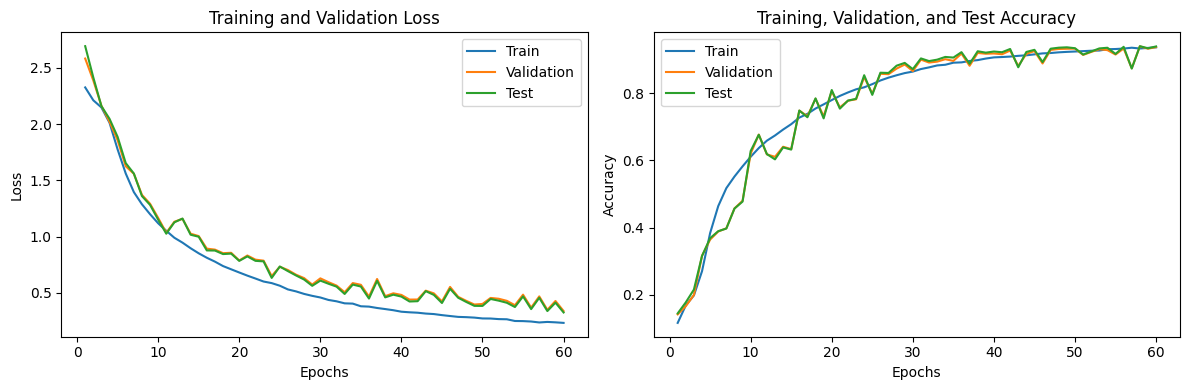

In [ ]:
# Set random seed for reproducibility - running time is 2hra
seed = 5
torch.manual_seed(seed)



# Train the model
# Create the model, loss function, and optimizer
activation_function_relu = nn.ReLU()
model_relu = FeedForwardNN(hidden_size=512, num_hidden_layers=50, output_size=10, activation_function=activation_function_relu)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_relu.parameters(), lr=0.0003)
batch_size = 64


train_dataset = CustomDataset(train_images,train_labels,transform)
val_dataset = CustomDataset(val_images,val_labels,transform)
test_dataset = CustomDataset(test_images,test_labels,transform)
train_dataloader = create_dataloader(train_dataset, batch_size)
val_dataloader = create_dataloader(val_dataset, batch_size)
test_dataloader = create_dataloader(test_dataset, batch_size)

train_losses, val_losses, test_losses, train_accuracies, val_accuracies, test_accuracies = inbuilt_train_and_test_model(model_relu, train_dataloader, val_dataloader, test_dataloader , criterion, optimizer, num_epochs=60)


# Plotting loss and accuracy graphs
epochs_range=range(1, 61)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Train')
plt.plot(epochs_range, val_losses, label='Validation')
plt.plot(epochs_range, test_losses, label='Test')
# plt.axhline(y=final_test_loss, color='r', linestyle='--', label='Test')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Train')
plt.plot(epochs_range, val_accuracies, label='Validation')
plt.plot(epochs_range, test_accuracies, label='Test')
# plt.axhline(y=final_test_accuracy, color='r', linestyle='--', label='Test')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training, Validation, and Test Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

50 hidden layers is the best i could achieve . Also i could have kept increasing n , but accuracy was falling below 80% which is pretty useless, so i stopped here.

<br><br><br>
<h3> BONUS Q2) Time for custom Backpropagation</h3>

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


final train time=  129.68306970596313  seconds


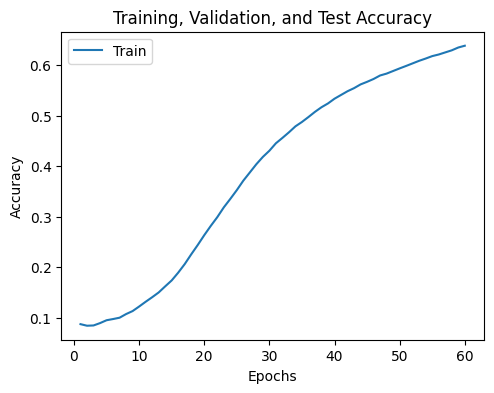

In [12]:
def scratch_train_and_test_model(model, train_loader, val_loader, test_loader, criterion, optimizer, num_epochs=60):
    train_accuracies=[]

    start_time = time.time()
    for epoch in range(num_epochs):

        # training mode of model
        total_loss, correct, total = 0, 0, 0

        for inputs, labels in train_loader:
            # optimizer.zero_grad()  # clear the previous grads because the new ones shouldn't be dependent on them (pytorch inherently stores them)
            # inputs, labels = inputs.to('cuda'), labels.to('cuda')

            outputs = model.forward(inputs)
            loss = criterion.forward(outputs, labels)
            criterion.backward(model)  # backpropagates the losses --------
            optimizer.step(model) # updates all the gradients of previous layers

            total_loss += loss
            _, predicted = torch.max(outputs.data, 1) # softmax probs to highest prob class
            total += labels.size(0) # get the no. of samples in a batch
            correct += (predicted == labels).sum().item() # no. of correct

        # train_loss = total_loss / len(train_loader)
        train_accuracy = correct / total
        # train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)


    end_time = time.time()
    total_time=(end_time - start_time)
    print("final train time= ",total_time," seconds")
    return train_accuracies






# Set random seed for reproducibility
seed = 5
torch.manual_seed(seed)



# Train the model
# Create the model, loss function, and optimizer
activation_function_relu = Relu()
model_relu = FeedForwardNet(28*28,32,10,activation_function_relu)
criterion = CrossEntropyLossScratch()
optimizer = StochasticGD(0.0003,1.0)
batch_size = 2048


train_dataset = CustomDataset(train_images,train_labels,transform)
val_dataset = CustomDataset(val_images,val_labels,transform)
test_dataset = CustomDataset(test_images,test_labels,transform)
train_dataloader = create_dataloader(train_dataset, batch_size)
val_dataloader = create_dataloader(val_dataset, batch_size)
test_dataloader = create_dataloader(test_dataset, batch_size)

train_accuracies= scratch_train_and_test_model(model_relu, train_dataloader, val_dataloader, test_dataloader , criterion, optimizer, num_epochs=60)



# Plotting loss and accuracy graphs
epochs_range=range(1, 61)


plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_accuracies, label='Train')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training, Validation, and Test Accuracy')
plt.legend()
plt.show()


